Starting grid search for optimal parameters...
New best parameters found: {'min_area': 75, 'canny_low': 25, 'canny_high': 90, 'circularity': 0.44, 'min_radius': 25}
Coins detected: 30
New best parameters found: {'min_area': 75, 'canny_low': 25, 'canny_high': 90, 'circularity': 0.44, 'min_radius': 30}
Coins detected: 31
New best parameters found: {'min_area': 75, 'canny_low': 25, 'canny_high': 100, 'circularity': 0.44, 'min_radius': 30}
Coins detected: 32
New best parameters found: {'min_area': 75, 'canny_low': 30, 'canny_high': 100, 'circularity': 0.44, 'min_radius': 30}
Coins detected: 33

Final Parameters:
Min Area: 75
Canny Low: 30
Canny High: 100
Circularity: 0.44
Min Radius: 30

Total coins detected: 33


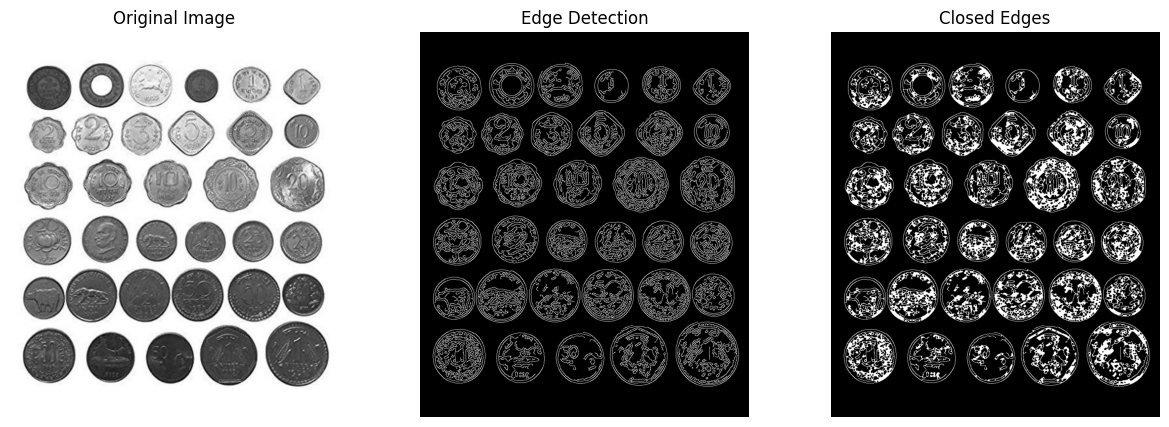

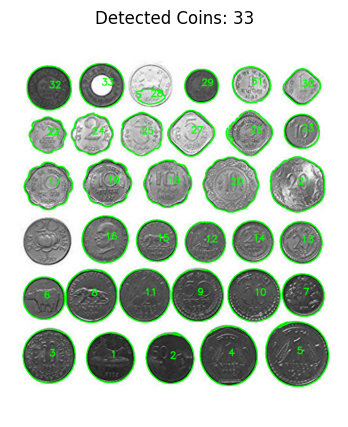

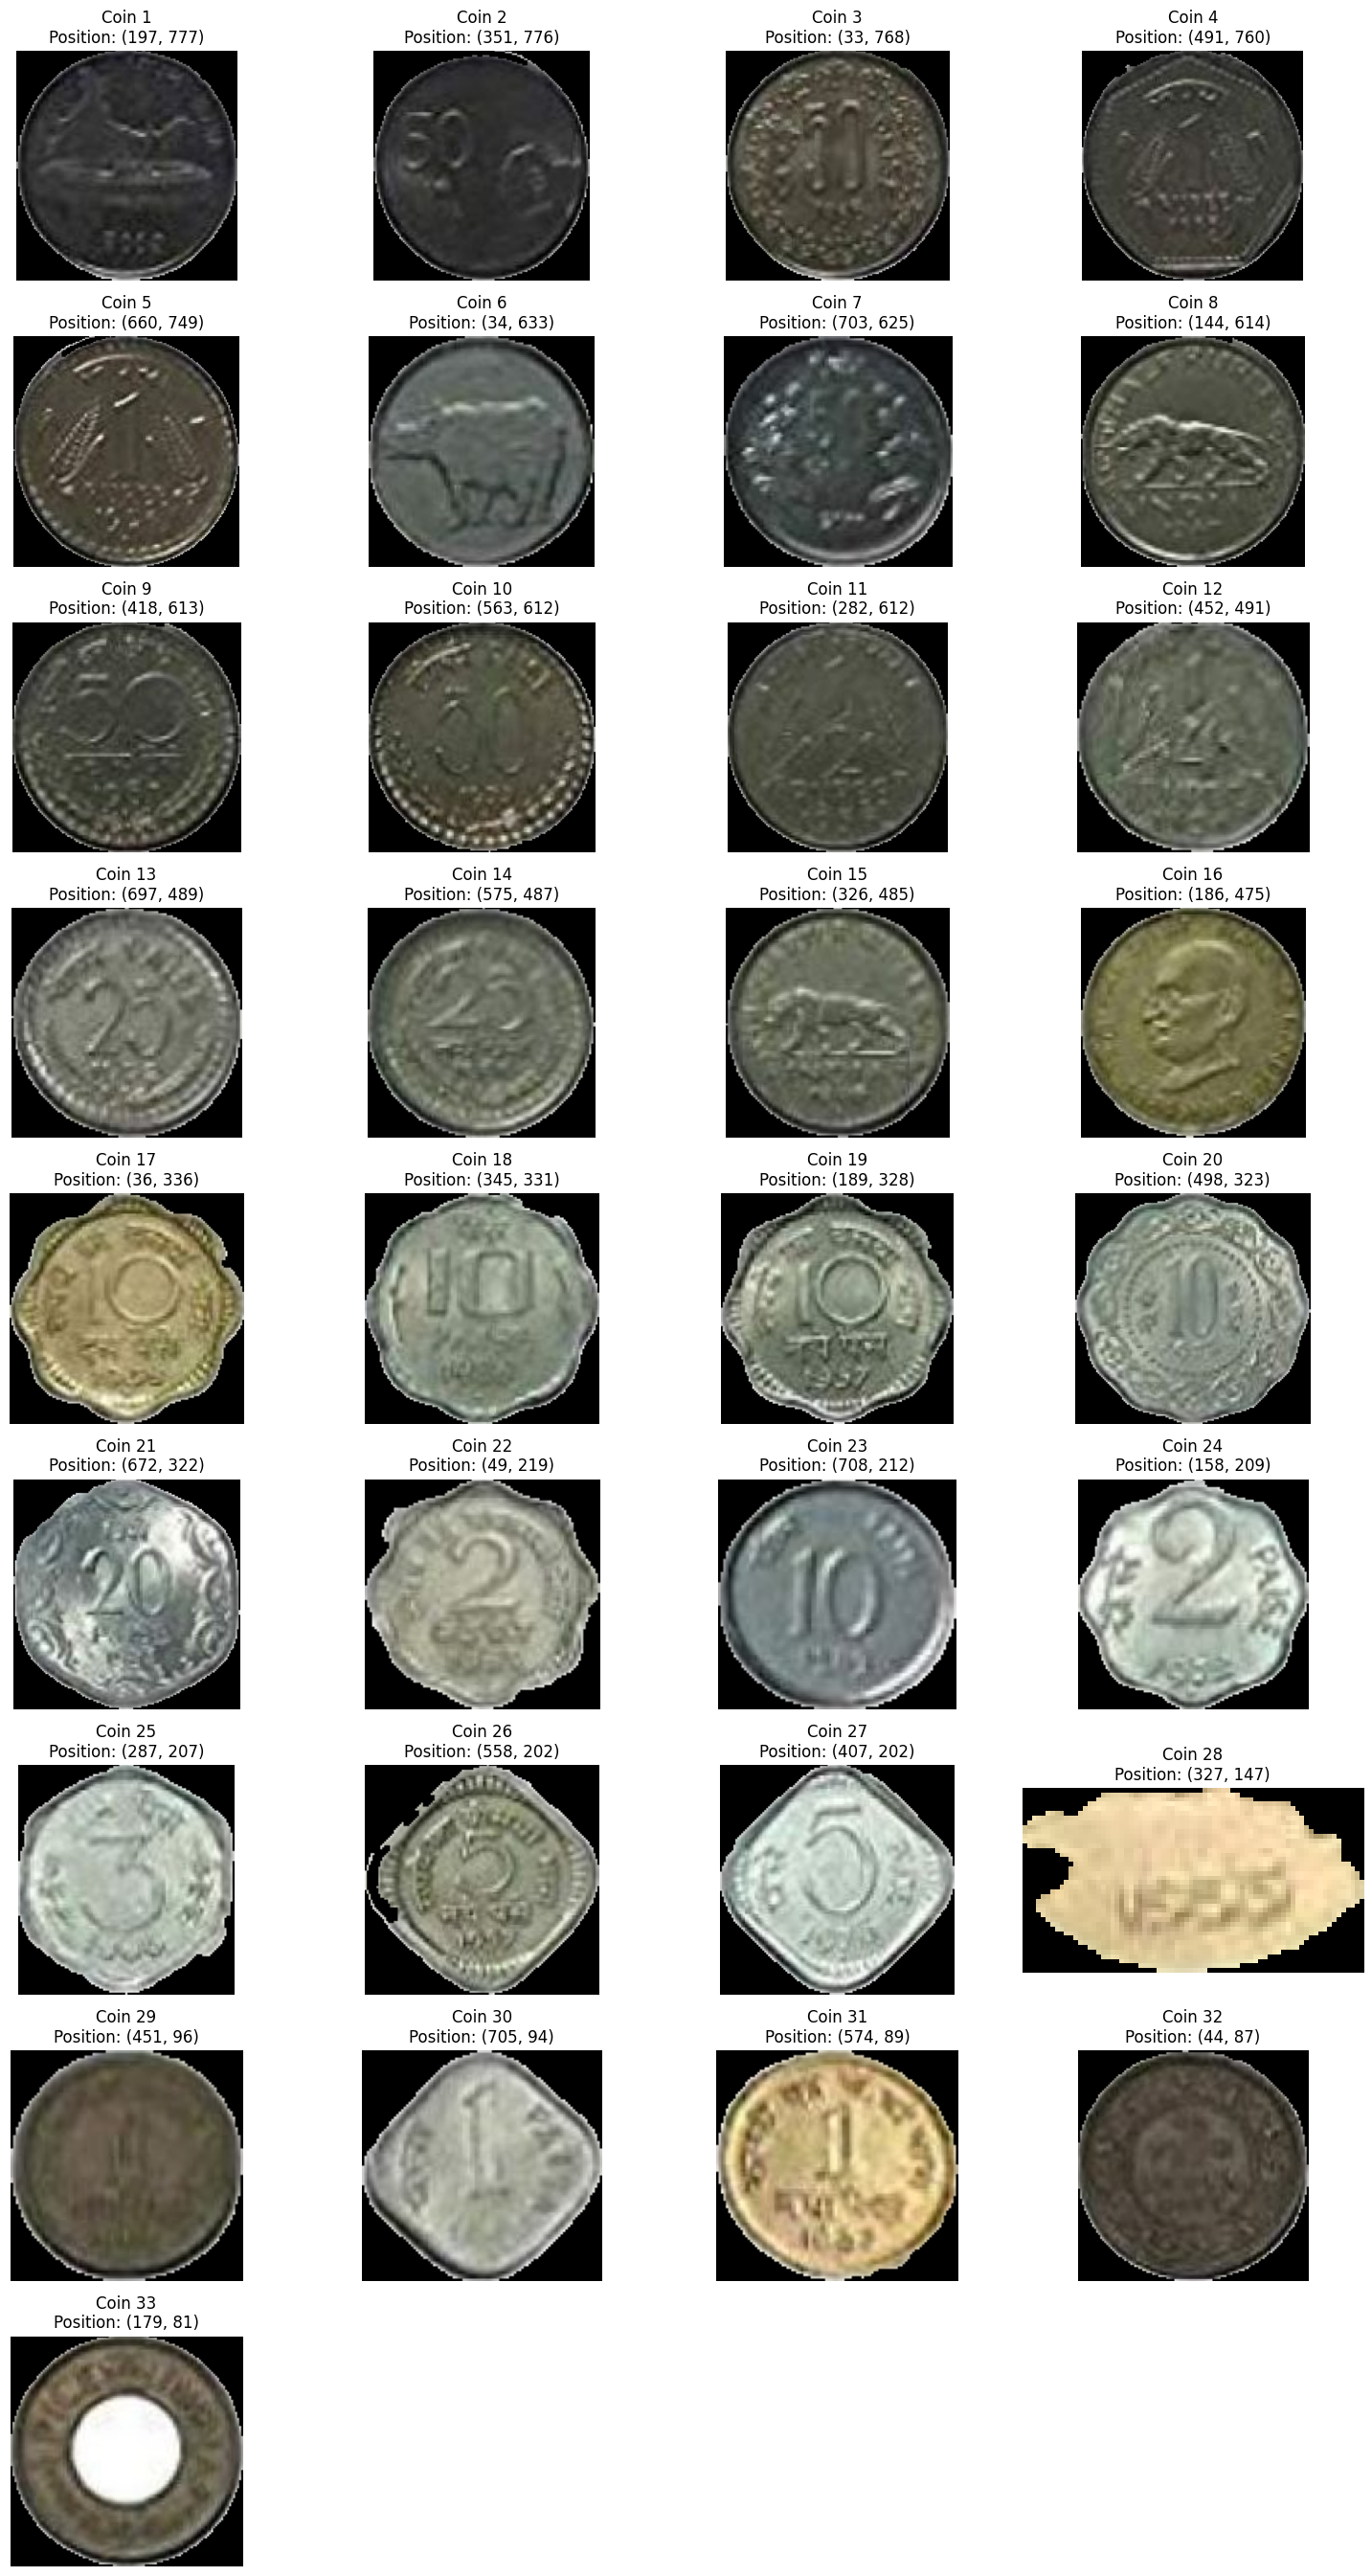

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math

class CoinDetector:
    def __init__(self, min_area=200, max_area=50000, kernel_size=(5, 5), min_radius=25):
        """
        Initialize the coin detector with optimized parameters.
        """
        self.min_area = min_area
        self.max_area = max_area
        self.kernel = np.ones(kernel_size, np.uint8)
        self.min_circularity = 0.75  # Increased for better circularity detection
        self.min_coin_distance = 10  # Reduced to detect closer coins
        self.min_radius = min_radius  # Minimum radius for detected coins

    def preprocess_image(self, image, blur_kernel=(7, 7), canny_low=30, canny_high=100):
        """
        Enhanced preprocessing with contrast improvement and optimized parameters.
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        # Denoise and detect edges
        blurred = cv2.GaussianBlur(enhanced, blur_kernel, 0)
        edges = cv2.Canny(blurred, canny_low, canny_high)
        return gray, edges

    def close_edges(self, edges):
        """
        Enhanced morphological operations with multi-scale processing
        and adaptive gap closing.
        """
        # Define multiple kernels for different scales
        small_kernel = np.ones((3, 3), np.uint8)
        medium_kernel = np.ones((5, 5), np.uint8)

        # First pass: Close small gaps while preserving details
        dilated1 = cv2.dilate(edges, small_kernel, iterations=1)
        eroded1 = cv2.erode(dilated1, small_kernel, iterations=1)

        # Second pass: Handle larger gaps
        dilated2 = cv2.dilate(eroded1, medium_kernel, iterations=1)
        eroded2 = cv2.erode(dilated2, medium_kernel, iterations=1)

        # Combine results from both passes
        combined = cv2.addWeighted(eroded1, 0.6, eroded2, 0.4, 0)

        # Final refinement
        closed_edges = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, small_kernel)

        # Strengthen weak edges
        edges_thresh = cv2.threshold(closed_edges, 50, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Final closing to ensure connectivity
        final_closed = cv2.morphologyEx(edges_thresh, cv2.MORPH_CLOSE, small_kernel)

        return final_closed

    def calculate_circularity(self, contour):
        """
        Calculate circularity of a contour.
        """
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            return 0
        return 4 * np.pi * area / (perimeter * perimeter)

    def get_contour_center(self, contour):
        """
        Calculate the center of a contour.
        """
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            return (cx, cy)
        return None

    def calculate_radius(self, contour):
        """
        Calculate the radius of a contour using the minimum enclosing circle.
        """
        (x, y), radius = cv2.minEnclosingCircle(contour)
        return radius

    def separate_merged_coins(self, contours):
        """
        Separate merged coins based on distance and circularity.
        """
        centers = []
        valid_contours = []

        # First pass: calculate centers and check circularity
        for cnt in contours:
            circularity = self.calculate_circularity(cnt)
            radius = self.calculate_radius(cnt)
            if circularity > self.min_circularity and radius >= self.min_radius:
                center = self.get_contour_center(cnt)
                if center:
                    centers.append(center)
                    valid_contours.append(cnt)

        # Second pass: check distances between centers
        separated_contours = []
        for i, cnt in enumerate(valid_contours):
            too_close = False
            for j, other_center in enumerate(centers):
                if i != j:
                    dist = np.sqrt((centers[i][0] - other_center[0]) ** 2 +
                              (centers[i][1] - other_center[1]) ** 2)
                    if dist < self.min_coin_distance:
                        too_close = True
                        break
            if not too_close:
                separated_contours.append(cnt)

        return separated_contours

    def find_coins(self, closed_edges):
        """
        Enhanced coin detection with better contour filtering.
        """
        # Find all contours
        contours, _ = cv2.findContours(closed_edges, cv2.RETR_LIST,
                                     cv2.CHAIN_APPROX_SIMPLE)

        # Filter by area and radius
        area_filtered = [cnt for cnt in contours
                        if self.min_area < cv2.contourArea(cnt) < self.max_area
                        and self.calculate_radius(cnt) >= self.min_radius]

        # Separate merged coins and apply circularity check
        return self.separate_merged_coins(area_filtered)

    def segment_coins(self, image, contours):
        """
        Improved coin segmentation with position tracking.
        """
        segmented_coins = []
        positions = []

        for cnt in contours:
            # Create mask for segmentation
            mask = np.zeros_like(image if len(image.shape) == 2
                               else image[:, :, 0])
            cv2.drawContours(mask, [cnt], -1, (255), thickness=cv2.FILLED)

            # Apply mask and crop
            segmented = cv2.bitwise_and(image, image if len(image.shape) == 2
                                      else cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = segmented[y:y + h, x:x + w]

            # Store results
            segmented_coins.append(cropped)
            positions.append((x, y, w, h))

        return segmented_coins, positions

    def visualize_results(self, original, edges, closed_edges, contours,
                         segmented_coins, positions):
        """
        Enhanced visualization with detailed information.
        """
        # Step 1: Processing steps
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(original, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(closed_edges, cmap='gray')
        plt.title('Closed Edges')
        plt.axis('off')
        plt.show()

        # Step 2: Contour visualization
        contour_image = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        for i, cnt in enumerate(contours):
            # Draw contour with unique color
            color = (0, 255, 0)  # Green for all contours
            cv2.drawContours(contour_image, [cnt], -1, color, 2)

            # Add contour number
            center = self.get_contour_center(cnt)
            if center:
                cv2.putText(contour_image, str(i + 1), center,
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detected Coins: {len(contours)}')
        plt.axis('off')
        plt.show()

        # Step 3: Segmented coins
        if segmented_coins:
            num_coins = len(segmented_coins)
            num_rows = math.ceil(num_coins / 4)
            fig, axes = plt.subplots(num_rows, min(4, num_coins),
                                   figsize=(15, 3 * num_rows))
            if num_rows == 1 and num_coins == 1:
                axes = [axes]
            elif num_rows == 1:
                axes = axes.flatten()
            else:
                axes = axes.flatten()

            for i in range(len(axes)):
                if i < num_coins:
                    coin = segmented_coins[i]
                    x, y, w, h = positions[i]
                    if len(coin.shape) == 3:
                        coin_rgb = cv2.cvtColor(coin, cv2.COLOR_BGR2RGB)
                    else:
                        coin_rgb = coin
                    axes[i].imshow(coin_rgb)
                    axes[i].set_title(f'Coin {i + 1}\nPosition: ({x}, {y})')
                    axes[i].axis('off')
                else:
                    axes[i].axis('off')

            plt.tight_layout()
            plt.show()

    def grid_search_parameters(self, image):
        """
        Perform grid search to find optimal parameters for coin detection.
        """
        # Parameter ranges to search
        min_areas = [75, 85, 95, 100, 125, 150]    # Lower min_area to account for ring shape
        canny_lows = [25, 30, 35]
        canny_highs = [90, 100, 120]
        circularities = [0.44, 0.445, 0.45, 0.47, 0.5]
        min_radii = [25, 27, 30]       # Include lower radius values
        #max_areas = [5000, 7500, 10000]  # Ensure it's not excluding based on max area

        best_params = None
        best_count = 0

        print("Starting grid search for optimal parameters...")

        for min_area in min_areas:
            for canny_low in canny_lows:
                for canny_high in canny_highs:
                    for circularity in circularities:
                        for min_radius in min_radii:
                            # Update parameters
                            self.min_area = min_area
                            self.min_circularity = circularity
                            self.min_radius = min_radius

                            # Process image with current parameters
                            gray, edges = self.preprocess_image(image,
                                                              canny_low=canny_low,
                                                              canny_high=canny_high)
                            closed_edges = self.close_edges(edges)
                            contours = self.find_coins(closed_edges)

                            # Check if this is the best result so far
                            coin_count = len(contours)
                            if coin_count > best_count:
                                best_count = coin_count
                                best_params = {
                                    'min_area': min_area,
                                    'canny_low': canny_low,
                                    'canny_high': canny_high,
                                    'circularity': circularity,
                                    'min_radius': min_radius
                                }
                                print(f"New best parameters found: {best_params}")
                                print(f"Coins detected: {best_count}")

        return best_params


def main():
    # Initialize detector
    detector = CoinDetector()

    # Load image
    image = cv2.imread('/content/Indian_Coins.jpg')
    if image is None:
        raise ValueError("Could not load image")

    # Perform grid search
    best_params = detector.grid_search_parameters(image)

    # Update detector with best parameters
    detector.min_area = best_params['min_area']
    detector.min_circularity = best_params['circularity']
    detector.min_radius = best_params['min_radius']

    # Process image with optimal parameters
    gray, edges = detector.preprocess_image(image,
                                          canny_low=best_params['canny_low'],
                                          canny_high=best_params['canny_high'])
    closed_edges = detector.close_edges(edges)
    contours = detector.find_coins(closed_edges)
    segmented_coins, positions = detector.segment_coins(image, contours)

    # Print final parameters and results
    print("\nFinal Parameters:")
    print(f"Min Area: {best_params['min_area']}")
    print(f"Canny Low: {best_params['canny_low']}")
    print(f"Canny High: {best_params['canny_high']}")
    print(f"Circularity: {best_params['circularity']}")
    print(f"Min Radius: {best_params['min_radius']}")
    print(f"\nTotal coins detected: {len(contours)}")

    # Visualize results
    detector.visualize_results(gray, edges, closed_edges, contours,
                             segmented_coins, positions)


if __name__ == "__main__":
    main()